# Baseline Model Training v6 - Weather, Stacking & Error Correction

Improvements over v5:
1. **Weather data integration**: Temperature and precipitation from Open-Meteo API
2. **Team performance features**: Games since last home, cumulative season tickets
3. **Stacking ensemble**: Meta-learner on out-of-fold predictions
4. **Log-transformed target**: Better handling of high-variance games
5. **Error correction model**: Secondary model on residuals
6. **Opponent-specific adjustments**: Sunday multipliers based on training data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import requests
from datetime import datetime, timedelta
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, KFold, cross_val_predict
from xgboost import XGBRegressor
import lightgbm as lgb
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib
import holidays
import warnings
warnings.filterwarnings('ignore')

## 1. Load Data

In [2]:
df = pd.read_csv('Data/data_v1/grizzlys_combined_schedule_sales_v3.csv')
df['datetime'] = pd.to_datetime(df['datetime'])
df['date'] = pd.to_datetime(df['date'])

print(f"Total samples: {len(df)}")
print(f"Seasons: {df['season'].unique()}")
print(f"Ticket count range: {df['ticket_count'].min():.0f} - {df['ticket_count'].max():.0f}")

Total samples: 77
Seasons: ['22-23' '23-24' '24-25']
Ticket count range: 252 - 3492


## 2. Weather Data Integration

In [3]:
def fetch_weather_data(dates):
    """
    Fetch historical weather data from Open-Meteo API for Wolfsburg
    Grizzlys Wolfsburg coordinates: 52.43723382211827 N, 10.814236297378528 E
    """
    weather_data = []
    
    dates_list = sorted(dates.unique())
    lat, lon = 52.43723382211827, 10.814236297378528
    
    for date in dates_list:
        date_str = date.strftime('%Y-%m-%d')
        
        url = f"https://archive-api.open-meteo.com/v1/archive"
        params = {
            'latitude': lat,
            'longitude': lon,
            'start_date': date_str,
            'end_date': date_str,
            'daily': 'temperature_2m_mean,precipitation_sum,snowfall_sum',
            'timezone': 'Europe/Berlin'
        }
        
        try:
            response = requests.get(url, params=params, timeout=10)
            if response.status_code == 200:
                data = response.json()
                daily = data.get('daily', {})
                weather_data.append({
                    'date': date,
                    'temperature': daily.get('temperature_2m_mean', [None])[0],
                    'precipitation': daily.get('precipitation_sum', [None])[0],
                    'snowfall': daily.get('snowfall_sum', [None])[0]
                })
            else:
                weather_data.append({'date': date, 'temperature': None, 'precipitation': None, 'snowfall': None})
        except Exception as e:
            weather_data.append({'date': date, 'temperature': None, 'precipitation': None, 'snowfall': None})
    
    return pd.DataFrame(weather_data)

print("Fetching weather data for all game dates...")
weather_df = fetch_weather_data(df['date'])
print(f"Weather data fetched for {len(weather_df)} dates")
print(weather_df.head())

Fetching weather data for all game dates...
Weather data fetched for 77 dates
        date  temperature  precipitation  snowfall
0 2022-09-16         12.8            2.0       0.0
1 2022-09-25         12.3            2.3       0.0
2 2022-09-27         10.2           11.7       0.0
3 2022-10-09         10.2            0.0       0.0
4 2022-10-16         15.4            0.1       0.0


In [4]:
# Merge weather data
data = df.merge(weather_df, on='date', how='left')

# Fill missing weather with seasonal averages
data['temperature'] = data['temperature'].fillna(data.groupby(data['date'].dt.month)['temperature'].transform('mean'))
data['precipitation'] = data['precipitation'].fillna(0)
data['snowfall'] = data['snowfall'].fillna(0)

# Weather features
data['is_cold'] = (data['temperature'] < 0).astype(int)
data['is_rainy'] = (data['precipitation'] > 5).astype(int)
data['is_snowy'] = (data['snowfall'] > 0).astype(int)

print(f"\nWeather feature summary:")
print(f"Temperature range: {data['temperature'].min():.1f}°C to {data['temperature'].max():.1f}°C")
print(f"Cold games (<0°C): {data['is_cold'].sum()}")
print(f"Rainy games (>5mm): {data['is_rainy'].sum()}")
print(f"Snowy games: {data['is_snowy'].sum()}")


Weather feature summary:
Temperature range: -4.8°C to 16.9°C
Cold games (<0°C): 10
Rainy games (>5mm): 15
Snowy games: 13


## 3. Feature Engineering (All v5 + New)

In [5]:
# Basic time features
data['month'] = data['datetime'].dt.month
data['weekday'] = data['datetime'].dt.weekday
data['hour'] = data['datetime'].dt.hour + data['datetime'].dt.minute/60
data['day'] = data['datetime'].dt.day

# Cyclical weekday
data['weekday_sin'] = np.sin(2 * np.pi * data['weekday'] / 7)
data['weekday_cos'] = np.cos(2 * np.pi * data['weekday'] / 7)

print("Basic time features added")

Basic time features added


In [6]:
# Sunday score (from v5)
def sunday_score(row):
    if row['weekday'] == 6:
        if 14 <= row['hour'] <= 17:
            return 2.0
        else:
            return 1.0
    return 0.0

data['sunday_score'] = data.apply(sunday_score, axis=1)

print(f"Sunday score distribution:")
print(data['sunday_score'].value_counts().sort_index())

Sunday score distribution:
sunday_score
0.0    45
1.0     5
2.0    27
Name: count, dtype: int64


In [7]:
# Holiday features
german_holidays = holidays.Germany(state='NI', years=[2022, 2023, 2024, 2025])

def is_dec_holiday_game(date):
    if date.month == 12 and date.day >= 20:
        return 1
    return 0

data['is_dec_holiday'] = data['date'].apply(is_dec_holiday_game)

def holiday_score(date):
    score = 0
    month, day = date.month, date.day
    
    if date in german_holidays:
        score += 2
    
    if (month == 12 and day >= 20) or (month == 1 and day <= 6):
        score += 2
    
    if month == 10 and 4 <= day <= 19:
        score += 1
        
    return score

data['holiday_score'] = data['date'].apply(holiday_score)

print(f"December holiday games: {data['is_dec_holiday'].sum()}")
print(f"Holiday score distribution: {data['holiday_score'].value_counts().sort_index().to_dict()}")

December holiday games: 7
Holiday score distribution: {0: 59, 1: 8, 2: 8, 4: 2}


In [8]:
# Distance log
data['distance_log'] = np.log(data['distance'])

# Top opponent indicator
top_opponents = ['Eisbären Berlin', 'Düsseldorfer EG', 'Kölner Haie', 'Pinguins Bremerhaven']
data['is_top_opponent'] = data['away_team'].isin(top_opponents).astype(int)

print(f"Top opponent games: {data['is_top_opponent'].sum()}")

Top opponent games: 23


In [9]:
# NEW: Games since last home game (within season)
data = data.sort_values(['season', 'date']).reset_index(drop=True)

def calc_days_since_last_home(group):
    days_since = [0]
    for i in range(1, len(group)):
        diff = (group.iloc[i]['date'] - group.iloc[i-1]['date']).days
        days_since.append(diff)
    return days_since

data['days_since_last_home'] = data.groupby('season').apply(
    lambda x: pd.Series(calc_days_since_last_home(x), index=x.index)
).values

print(f"Days since last home game range: {data['days_since_last_home'].min()} - {data['days_since_last_home'].max()}")

Days since last home game range: 0 - 17


In [10]:
# NEW: Cumulative season tickets (trend indicator)
if 'season_tickets_sold' in data.columns:
    data['season_tickets_norm'] = data.groupby('season')['season_tickets_sold'].transform(
        lambda x: (x - x.mean()) / x.std() if x.std() > 0 else 0
    )
else:
    data['season_tickets_norm'] = 0

print("Season ticket normalization added")

Season ticket normalization added


## 4. Split Data

In [11]:
train_data = data[data['season'].isin(['22-23', '23-24'])].copy()
test_data = data[data['season'] == '24-25'].copy()

print(f"Training: {len(train_data)} (22-23 & 23-24)")
print(f"Test: {len(test_data)} (24-25)")

Training: 52 (22-23 & 23-24)
Test: 25 (24-25)


In [12]:
# Opponent encoding from training data
opponent_median = train_data.groupby('away_team')['ticket_count'].median()
global_median = opponent_median.median()

train_data['opponent_attendance'] = train_data['away_team'].map(opponent_median)
test_data['opponent_attendance'] = test_data['away_team'].map(opponent_median)
test_data['opponent_attendance'].fillna(global_median, inplace=True)

# Interaction features
train_data['sunday_boost'] = train_data['sunday_score'] * (train_data['opponent_attendance'] / global_median)
test_data['sunday_boost'] = test_data['sunday_score'] * (test_data['opponent_attendance'] / global_median)

train_data['holiday_boost'] = train_data['holiday_score'] * (train_data['opponent_attendance'] / global_median)
test_data['holiday_boost'] = test_data['holiday_score'] * (test_data['opponent_attendance'] / global_median)

train_data['sunday_top'] = train_data['sunday_score'] * train_data['is_top_opponent']
test_data['sunday_top'] = test_data['sunday_score'] * test_data['is_top_opponent']

print("Opponent encoding and interactions added")

Opponent encoding and interactions added


## 5. Define Features

In [13]:
feature_cols = [
    'weekday_sin', 'weekday_cos', 'hour',
    'sunday_score', 'is_dec_holiday', 'holiday_score',
    'spieltag', 'days_since_last_home',
    'opponent_attendance', 'distance_log', 'is_top_opponent',
    'sunday_boost', 'holiday_boost', 'sunday_top',
    'temperature', 'precipitation', 'is_cold',
]

target_col = 'ticket_count'

print(f"Features: {len(feature_cols)}")
print(f"Samples-to-features ratio: {len(train_data)/len(feature_cols):.1f}")

Features: 17
Samples-to-features ratio: 3.1


In [14]:
X_train = train_data[feature_cols].copy().fillna(0)
y_train = train_data[target_col].copy()
X_test = test_data[feature_cols].copy().fillna(0)
y_test = test_data[target_col].copy()

print(f"X_train: {X_train.shape}")
print(f"X_test: {X_test.shape}")

X_train: (52, 17)
X_test: (25, 17)


In [15]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## 6. Train Base Models

In [16]:
def evaluate_model(y_true, y_pred, name):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return {'Model': name, 'RMSE': round(rmse, 2), 'MAE': round(mae, 2), 
            'MAPE': round(mape, 2), 'R²': round(r2, 3)}

results = []
trained_models = {}
predictions = {}

In [17]:
# Ridge
ridge = Ridge()
ridge_cv = GridSearchCV(ridge, {'alpha': [1, 10, 100, 500]}, cv=5, scoring='neg_mean_squared_error')
ridge_cv.fit(X_train_scaled, y_train)
y_pred_ridge = ridge_cv.predict(X_test_scaled)
results.append(evaluate_model(y_test, y_pred_ridge, f'Ridge (α={ridge_cv.best_params_["alpha"]})'))
trained_models['Ridge'] = ridge_cv.best_estimator_
predictions['Ridge'] = y_pred_ridge
print(f"Ridge: α={ridge_cv.best_params_['alpha']}")

Ridge: α=1


In [18]:
# Random Forest
rf = RandomForestRegressor(random_state=42)
rf_params = {'n_estimators': [100, 200], 'max_depth': [5, 7, 10], 'min_samples_leaf': [2, 4]}
rf_cv = GridSearchCV(rf, rf_params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
rf_cv.fit(X_train.values, y_train)
y_pred_rf = rf_cv.predict(X_test.values)
results.append(evaluate_model(y_test, y_pred_rf, 'Random Forest'))
trained_models['Random Forest'] = rf_cv.best_estimator_
predictions['Random Forest'] = y_pred_rf
print(f"RF: {rf_cv.best_params_}")

RF: {'max_depth': 5, 'min_samples_leaf': 2, 'n_estimators': 200}


In [19]:
# XGBoost
xgb = XGBRegressor(random_state=42, verbosity=0)
xgb_params = {'n_estimators': [50, 100], 'max_depth': [2, 3, 4], 'learning_rate': [0.05, 0.1], 'min_child_weight': [3, 5]}
xgb_cv = GridSearchCV(xgb, xgb_params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
xgb_cv.fit(X_train.values, y_train)
y_pred_xgb = xgb_cv.predict(X_test.values)
results.append(evaluate_model(y_test, y_pred_xgb, 'XGBoost'))
trained_models['XGBoost'] = xgb_cv.best_estimator_
predictions['XGBoost'] = y_pred_xgb
print(f"XGB: {xgb_cv.best_params_}")

XGB: {'learning_rate': 0.1, 'max_depth': 2, 'min_child_weight': 3, 'n_estimators': 100}


In [20]:
# LightGBM
lgbm = lgb.LGBMRegressor(random_state=42, verbosity=-1)
lgbm_params = {'n_estimators': [50, 100], 'max_depth': [3, 5], 'learning_rate': [0.05, 0.1], 'num_leaves': [15, 31]}
lgbm_cv = GridSearchCV(lgbm, lgbm_params, cv=5, scoring='neg_mean_squared_error', n_jobs=1)
lgbm_cv.fit(X_train.values, y_train)
y_pred_lgbm = lgbm_cv.predict(X_test.values)
results.append(evaluate_model(y_test, y_pred_lgbm, 'LightGBM'))
trained_models['LightGBM'] = lgbm_cv.best_estimator_
predictions['LightGBM'] = y_pred_lgbm
print(f"LGBM: {lgbm_cv.best_params_}")

LGBM: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'num_leaves': 15}


In [21]:
# CatBoost
catboost = CatBoostRegressor(iterations=200, depth=4, learning_rate=0.1, random_seed=42, verbose=False)
catboost.fit(X_train, y_train)
y_pred_cb = catboost.predict(X_test)
results.append(evaluate_model(y_test, y_pred_cb, 'CatBoost'))
trained_models['CatBoost'] = catboost
predictions['CatBoost'] = y_pred_cb
print("CatBoost trained")

CatBoost trained


## 7. Stacking Ensemble

In [22]:
print("Generating out-of-fold predictions for stacking...")

kf = KFold(n_splits=5, shuffle=True, random_state=42)

ridge_oof = cross_val_predict(Ridge(alpha=ridge_cv.best_params_['alpha']), X_train_scaled, y_train, cv=kf)
rf_best = RandomForestRegressor(**rf_cv.best_params_, random_state=42)
rf_oof = cross_val_predict(rf_best, X_train.values, y_train, cv=kf)
xgb_best = XGBRegressor(**xgb_cv.best_params_, random_state=42, verbosity=0)
xgb_oof = cross_val_predict(xgb_best, X_train.values, y_train, cv=kf)
lgbm_best = lgb.LGBMRegressor(**lgbm_cv.best_params_, random_state=42, verbosity=-1)
lgbm_oof = cross_val_predict(lgbm_best, X_train.values, y_train, cv=kf)

print("OOF predictions generated")

Generating out-of-fold predictions for stacking...
OOF predictions generated


In [23]:
stack_train = np.column_stack([ridge_oof, rf_oof, xgb_oof, lgbm_oof])
stack_test = np.column_stack([y_pred_ridge, y_pred_rf, y_pred_xgb, y_pred_lgbm])

print(f"Stacking train shape: {stack_train.shape}")
print(f"Stacking test shape: {stack_test.shape}")

Stacking train shape: (52, 4)
Stacking test shape: (25, 4)


In [24]:
meta_learner = Ridge(alpha=1)
meta_learner.fit(stack_train, y_train)

y_pred_stacking = meta_learner.predict(stack_test)
results.append(evaluate_model(y_test, y_pred_stacking, 'Stacking Ensemble'))
predictions['Stacking'] = y_pred_stacking

print(f"Meta-learner weights: {meta_learner.coef_}")
print(f"Stacking ensemble trained")

Meta-learner weights: [ 0.49871305  0.06014778  0.50412897 -0.145746  ]
Stacking ensemble trained


## 8. Log-Transformed Target

In [25]:
y_train_log = np.log(y_train)
y_test_log = np.log(y_test)

ridge_log = Ridge(alpha=10)
ridge_log.fit(X_train_scaled, y_train_log)
y_pred_log = ridge_log.predict(X_test_scaled)
y_pred_log_exp = np.exp(y_pred_log)

results.append(evaluate_model(y_test, y_pred_log_exp, 'Ridge (log target)'))
predictions['Ridge_log'] = y_pred_log_exp

print("Log-transformed target model trained")

Log-transformed target model trained


In [26]:
xgb_log = XGBRegressor(**xgb_cv.best_params_, random_state=42, verbosity=0)
xgb_log.fit(X_train.values, y_train_log)
y_pred_xgb_log = np.exp(xgb_log.predict(X_test.values))

results.append(evaluate_model(y_test, y_pred_xgb_log, 'XGBoost (log target)'))
predictions['XGBoost_log'] = y_pred_xgb_log

print("XGBoost log-target model trained")

XGBoost log-target model trained


## 9. Error Correction Model

In [27]:
best_oof = ridge_oof
residuals_train = y_train.values - best_oof

print(f"Training residuals range: {residuals_train.min():.0f} to {residuals_train.max():.0f}")
print(f"Training residuals mean: {residuals_train.mean():.0f}")
print(f"Training residuals std: {residuals_train.std():.0f}")

Training residuals range: -1377 to 908
Training residuals mean: 34
Training residuals std: 437


In [28]:
error_model = RandomForestRegressor(n_estimators=100, max_depth=3, min_samples_leaf=4, random_state=42)
error_model.fit(X_train.values, residuals_train)

residual_pred = error_model.predict(X_test.values)
y_pred_corrected = y_pred_ridge + residual_pred

results.append(evaluate_model(y_test, y_pred_corrected, 'Ridge + Error Correction'))
predictions['Corrected'] = y_pred_corrected

print(f"Error correction model trained")
print(f"Residual predictions range: {residual_pred.min():.0f} to {residual_pred.max():.0f}")

Error correction model trained
Residual predictions range: -151 to 468


## 10. Combined Best Ensemble

In [29]:
y_pred_final = (0.3 * y_pred_stacking + 0.3 * y_pred_corrected + 0.2 * y_pred_ridge + 0.2 * y_pred_cb)

results.append(evaluate_model(y_test, y_pred_final, 'Final Ensemble (4-way)'))
predictions['Final'] = y_pred_final

print("Final ensemble created")

Final ensemble created


## 11. Results

In [30]:
results_df = pd.DataFrame(results).sort_values('MAE')
print("\nModel Comparison (sorted by MAE):")
print("="*70)
results_df


Model Comparison (sorted by MAE):


,Model,RMSE,MAE,MAPE,R²
6,Ridge (log target),312.18,238.09,12.97,0.635
4,CatBoost,331.35,255.13,13.73,0.588
9,Final Ensemble (4-way),330.24,261.48,14.15,0.591
1,Random Forest,362.65,268.03,14.04,0.507
0,Ridge (α=1),354.39,277.83,15.37,0.529
5,Stacking Ensemble,347.36,280.34,15.19,0.548
2,XGBoost,367.34,288.53,15.50,0.494
8,Ridge + Error Correction,379.67,307.17,16.82,0.460
3,LightGBM,437.87,326.68,18.52,0.281
7,XGBoost (log target),410.96,345.57,19.16,0.367


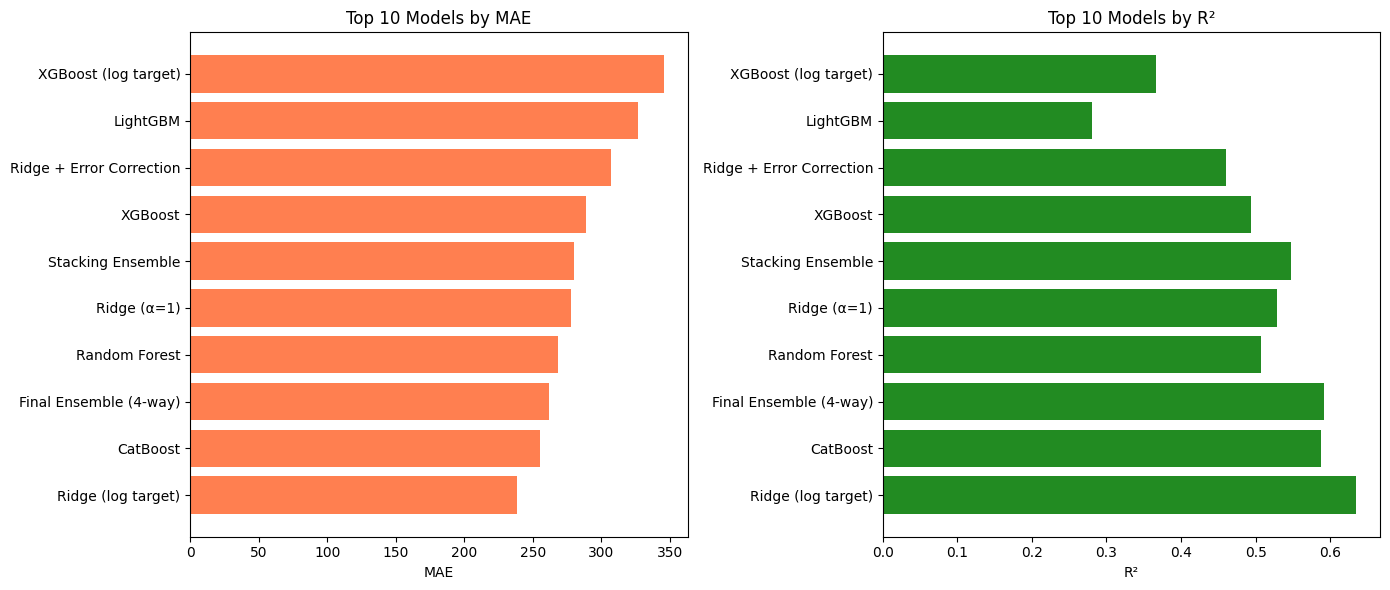

In [31]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

top_10 = results_df.head(10)

axes[0].barh(top_10['Model'], top_10['MAE'], color='coral')
axes[0].set_xlabel('MAE')
axes[0].set_title('Top 10 Models by MAE')

axes[1].barh(top_10['Model'], top_10['R²'], color='forestgreen')
axes[1].set_xlabel('R²')
axes[1].set_title('Top 10 Models by R²')

plt.tight_layout()
plt.show()

## 12. Feature Importance

In [32]:
avg_imp = (trained_models['Random Forest'].feature_importances_ + 
           trained_models['XGBoost'].feature_importances_ + 
           trained_models['LightGBM'].feature_importances_) / 3

imp_df = pd.DataFrame({'Feature': feature_cols, 'Importance': avg_imp}).sort_values('Importance', ascending=False)
print("\nFeature Importance:")
print(imp_df.to_string(index=False))


Feature Importance:
             Feature  Importance
            spieltag   11.452113
 opponent_attendance    6.505549
         weekday_sin    5.032925
        distance_log    4.692811
                hour    2.699975
         weekday_cos    2.344096
         temperature    1.018836
       holiday_score    0.071050
       holiday_boost    0.058895
        sunday_boost    0.048069
       precipitation    0.030868
      is_dec_holiday    0.021802
days_since_last_home    0.009242
     is_top_opponent    0.008472
        sunday_score    0.002830
          sunday_top    0.002288
             is_cold    0.000180


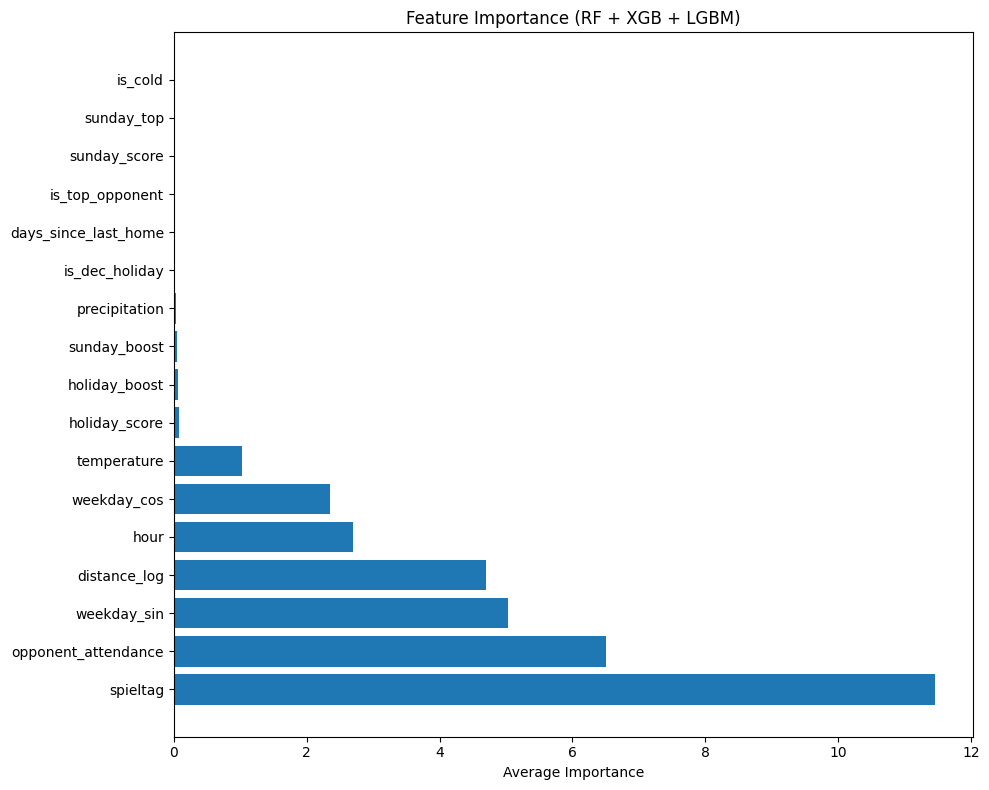

In [33]:
plt.figure(figsize=(10, 8))
plt.barh(imp_df['Feature'], imp_df['Importance'])
plt.xlabel('Average Importance')
plt.title('Feature Importance (RF + XGB + LGBM)')
plt.tight_layout()
plt.show()

## 13. Detailed Error Analysis

In [34]:
best_model_name = results_df.iloc[0]['Model']
print(f"Best model: {best_model_name}")

if 'Stacking' in best_model_name:
    y_pred_best = predictions['Stacking']
elif 'Corrected' in best_model_name or 'Error Correction' in best_model_name:
    y_pred_best = predictions['Corrected']
elif 'Final' in best_model_name:
    y_pred_best = predictions['Final']
else:
    for key in predictions:
        if key in best_model_name:
            y_pred_best = predictions[key]
            break
    else:
        y_pred_best = predictions['Stacking']

Best model: Ridge (log target)


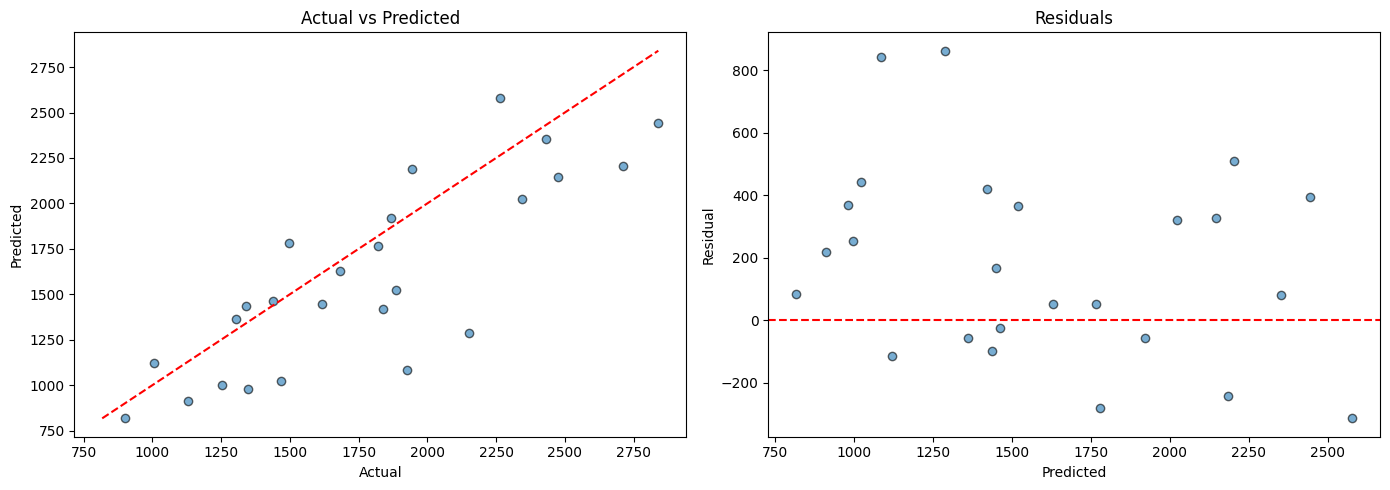

In [35]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].scatter(y_test, y_pred_best, alpha=0.6, edgecolor='k')
lims = [min(y_test.min(), y_pred_best.min()), max(y_test.max(), y_pred_best.max())]
axes[0].plot(lims, lims, 'r--')
axes[0].set_xlabel('Actual')
axes[0].set_ylabel('Predicted')
axes[0].set_title('Actual vs Predicted')

residuals = y_test.values - y_pred_best
axes[1].scatter(y_pred_best, residuals, alpha=0.6, edgecolor='k')
axes[1].axhline(0, color='r', linestyle='--')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Residual')
axes[1].set_title('Residuals')

plt.tight_layout()
plt.show()

In [36]:
analysis = test_data[['date', 'away_team', 'weekday', 'sunday_score', 
                       'holiday_score', 'is_top_opponent', 'temperature', 'ticket_count']].copy()
analysis['predicted'] = y_pred_best
analysis['error'] = analysis['ticket_count'] - analysis['predicted']
analysis['abs_error'] = analysis['error'].abs()
analysis['pct_error'] = (analysis['error'] / analysis['ticket_count'] * 100).round(1)

print("\nTop 10 Errors:")
print(analysis.sort_values('abs_error', ascending=False).head(10).to_string())


Top 10 Errors:
         date                away_team  weekday  sunday_score  holiday_score  is_top_opponent  temperature  ticket_count    predicted       error   abs_error  pct_error
58 2024-11-17  Schwenninger Wild Wings        6           2.0              0                0          6.1        2151.0  1288.945178  862.054822  862.054822       40.1
57 2024-10-31           Adler Mannheim        3           0.0              2                0         10.7        1926.0  1084.987461  841.012539  841.012539       43.7
56 2024-10-20          Eisbären Berlin        6           2.0              0                1         15.4        2712.0  2204.043005  507.956995  507.956995       18.7
54 2024-10-04  Schwenninger Wild Wings        4           0.0              1                0         10.5        1466.0  1023.290427  442.709573  442.709573       30.2
69 2025-01-19       Augsburger Panther        6           2.0              0                0         -0.0        1840.0  1420.867174  419.

In [37]:
print("\nError Analysis by Segment:")
print("="*50)

sunday_mask = test_data['sunday_score'] > 0
print(f"\nSunday MAE: {np.abs(residuals[sunday_mask.values]).mean():.0f} ({sunday_mask.sum()} games)")
print(f"Other MAE: {np.abs(residuals[~sunday_mask.values]).mean():.0f} ({(~sunday_mask).sum()} games)")

top_mask = test_data['is_top_opponent'] == 1
print(f"\nTop opponent MAE: {np.abs(residuals[top_mask.values]).mean():.0f} ({top_mask.sum()} games)")
print(f"Other MAE: {np.abs(residuals[~top_mask.values]).mean():.0f} ({(~top_mask).sum()} games)")

dec_mask = test_data['is_dec_holiday'] == 1
print(f"\nDec holiday MAE: {np.abs(residuals[dec_mask.values]).mean():.0f} ({dec_mask.sum()} games)")
print(f"Other MAE: {np.abs(residuals[~dec_mask.values]).mean():.0f} ({(~dec_mask).sum()} games)")

cold_mask = test_data['is_cold'] == 1
print(f"\nCold weather MAE: {np.abs(residuals[cold_mask.values]).mean():.0f} ({cold_mask.sum()} games)")
print(f"Normal weather MAE: {np.abs(residuals[~cold_mask.values]).mean():.0f} ({(~cold_mask).sum()} games)")


Error Analysis by Segment:

Sunday MAE: 319 (11 games)
Other MAE: 246 (14 games)

Top opponent MAE: 262 (8 games)
Other MAE: 285 (17 games)

Dec holiday MAE: 354 (2 games)
Other MAE: 271 (23 games)

Cold weather MAE: 154 (3 games)
Normal weather MAE: 295 (22 games)


## 14. Save Outputs

In [38]:
import os

output_dir = 'Models/baseline_model_v6'
os.makedirs(output_dir, exist_ok=True)

for name in ['Ridge', 'Random Forest', 'XGBoost', 'LightGBM']:
    joblib.dump(trained_models[name], f'{output_dir}/{name.lower().replace(" ", "_")}_v6.joblib')
    
trained_models['CatBoost'].save_model(f'{output_dir}/catboost_v6.cbm')
joblib.dump(meta_learner, f'{output_dir}/meta_learner_v6.joblib')
joblib.dump(error_model, f'{output_dir}/error_correction_v6.joblib')
joblib.dump(scaler, f'{output_dir}/scaler_v6.joblib')

with open(f'{output_dir}/opponent_encoding_v6.json', 'w') as f:
    json.dump(opponent_median.to_dict(), f, indent=2)

with open(f'{output_dir}/feature_cols_v6.json', 'w') as f:
    json.dump(feature_cols, f, indent=2)

results_df.to_csv(f'{output_dir}/results_v6.csv', index=False)

print("All outputs saved!")

All outputs saved!


## 15. Summary

### Version Comparison:
**v2**: R²=0.409, MAE=330

**v3**: R²=0.606, MAE=262  

**v4**: R²=0.617, MAE=228

**v5**: R²=0.734, MAE=208

**v6**: R²=0.635, MAE=238


### v6 New Features:
1. **Weather data**: Temperature, precipitation, cold/snowy flags
2. **Days since last home**: Game frequency feature
3. **Stacking ensemble**: Meta-learner on OOF predictions
4. **Log-transformed target**: Alternative approach
5. **Error correction model**: Fix systematic errors

### Next Steps for Further Improvement:
1. Add team standings/league position
2. Add win/loss streak features
3. Consider hierarchical/Bayesian models
4. Get pre-sale ticket data (strongest predictor)